In [1]:
import os, sumolib, ast, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

In [2]:
path_root = os.path.dirname(os.path.dirname(os.path.abspath('.')))
path_raw = os.path.join(path_root, 'data', 'tables', '20240729') # 원본 테이블 위치
path_table = os.path.join(path_root, 'test_0731', 'data', 'tables') # 만들 테이블 위치
path_intermediates = os.path.join(path_root, 'test_0731', 'intermediates') # match1을 저장할 위치
path_net = os.path.join(path_root, 'test_0731', 'data', 'networks', 'new_sungnam_network_internal_target_0721.net.xml') # 네트워크 위치
net = sumolib.net.readNet(path_net)

In [3]:
os.listdir(path_raw)

['(중원구) 스마트교차로_인접진입로 목록.csv',
 'signal_node_matching.csv',
 'TC_IF_TOD_DAY_PLAN.csv',
 'TC_IF_TOD_HOLIDAY_PLAN.csv',
 'TC_IF_TOD_RED_YELLO.csv',
 'TC_IF_TOD_WEEK_PLAN.csv',
 'TL_IF_SIGL.csv',
 'TL_IF_SIGL_CYCL.csv',
 'TM_FA_CRSRD.csv',
 'TN_IF_SIGL_FLOW.csv',
 'turn_type_info.csv',
 'uturn_data_info.csv']

In [4]:
inter_nos = {436, 437, 438, 442, 443, 444, 455, 456, 457, 458}
inter_nos = inter_nos - {444} # 444는 네트워크에 포함되어 있지 않음

In [5]:
# inter_info
inter_info = pd.read_csv(os.path.join(path_raw, '(중원구) 스마트교차로_인접진입로 목록.csv'))
rename_dict = {'교차로ID':'inter_no', '교차로명':'inter_name',
               '위도(WGS84)':'inter_lat', '경도(WGS84)':'inter_lon'}
inter_info = inter_info[list(rename_dict)]
inter_info = inter_info.rename(columns=rename_dict)
inter_info = inter_info[inter_info.inter_no.isin(inter_nos)].reset_index(drop=True)
inter_info['group_no'] = ''
inter_info['main_phase_no'] = ''
inter_info

inter_no   inter_name  inter_lat   inter_lon group_no main_phase_no
0       436      이배재 사거리  37.431661  127.179091                       
1       437     반포산업 사거리  37.431125  127.174188                       
2       438      코멕스 삼거리  37.431525  127.172163                       
3       442       대원 사거리  37.433410  127.159925                       
4       443    자이아파트 삼거리  37.432376  127.157714                       
5       455       금광중 후문  37.447485  127.171031                       
6       456     하원초교 삼거리  37.447184  127.169608                       
7       457      신구대 사거리  37.446709  127.167303                       
8       458  금광2동사무소 단일로  37.446106  127.164491

In [6]:
# inter_node
inter_node = pd.read_csv(os.path.join(path_raw, 'signal_node_matching.csv'), dtype={'node_id':str})
inter_node = inter_node.rename(columns={'signal_id':'inter_no'})
inter_node['inter_type'] = 'parent'
inter_node = inter_node[inter_node.inter_no.isin(inter_nos)].reset_index(drop=True)
inter_node

inter_no node_id inter_type
0       436  109836     parent
1       437  109986     parent
2       438  106350     parent
3       442  106332     parent
4       443  108769     parent
5       455  109901     parent
6       456  106231     parent
7       457  106234     parent
8       458  106238     parent

In [7]:
# 일대일대응 확인
print(len(inter_node) == inter_node.inter_no.nunique() == inter_node.node_id.nunique())
# 교차로번호 vs 노드id 간 딕셔너리
inter2node = dict(zip(inter_node.inter_no, inter_node.node_id))
node2inter = dict(zip(inter_node.node_id, inter_node.inter_no))
node_ids = {inter2node[inter_no] for inter_no in inter_nos}

True


In [8]:
# angle
angle = pd.read_csv(os.path.join(path_raw, 'TN_IF_SIGL_FLOW.csv'))
angle = angle.rename(columns={'CRSRD_ID':'inter_no',    'PHASE':'phase_no',
                              'RING':'ring_type',       'FLOW_NO':'move_no'})
# angle = angle.drop(columns=['STOS_NO'])
angle = angle[angle.move_no.isin(range(1,19))]
angle = angle[angle.inter_no.isin(inter_nos)]
angle = angle.reset_index(drop=True)\
    .sort_values(by=['inter_no', 'phase_no', 'ring_type']).reset_index(drop=True)
# display(angle[:60])
for ind, row in angle.iterrows():
    arrow = row.SIGL_ARROW

    # 위경도 추출
    # arrow = re.findall(r'-?\d+\.?\d*', arrow)
    arrow = [coord.lstrip(' ') for coord in arrow.split(',')]
    arrow = [coord.lstrip('[') for coord in arrow]
    arrow = [coord.rstrip(']') for coord in arrow]
    exists = all([bool(coord) for coord in arrow])
    if exists:
        y1, x1, y2, x2, y3, x3 = arrow

        # print(x1, y1, x2, y2, x3, y3)

        # 미터 단위로 변환
        x1, y1 = net.convertLonLat2XY(x1, y1)
        x2, y2 = net.convertLonLat2XY(x2, y2)
        x3, y3 = net.convertLonLat2XY(x3, y3)

        # # 시각화
        # plt.scatter(x1, y1, color='red')
        # plt.scatter(x2, y2, color='orange')
        # plt.scatter(x3, y3, color='yellow')
        # plt.axis('equal')
        # plt.show()

        # 진입각, 진출각 설정
        inc_angle = np.arctan2(y1 - y2, x1 - x2)
        out_angle = np.arctan2(y3 - y2, x3 - x2)
        inc_angle = inc_angle * 180 / np.pi
        out_angle = out_angle * 180 / np.pi
        inc_angle = int((90 - inc_angle) % 360)
        out_angle = int((90 - out_angle) % 360)

        # 각도코드 설정
        angle_code = str(inc_angle).zfill(3) + str(out_angle).zfill(3)
        # print(angle_code)
        angle.loc[ind, 'angle_code'] = angle_code
    else:
        angle.loc[ind, 'angle_code'] = None
# angle = angle[['inter_no', 'phase_no', 'ring_type', 'move_no', 'angle_code', 'SIGL_ARROW']]
angle = angle.drop(columns='SIGL_ARROW')
display(angle[:60])

inter_no  phase_no ring_type  move_no  STOS_NO angle_code
0        436         1         A        5        0     262358
1        436         1         B        2        0     262074
2        436         2         A        8        0     174355
3        436         2         B        3        0     172263
4        436         3         A        7        0     356074
5        436         3         B        4        0     355175
6        436         4         A        6        0     071263
7        436         4         B        1        0     074172
8        437         1         A        6        0     092287
9        437         1         B        2        0     264085
10       437         2         A        5        0     270357
11       437         2         B        1        0     085202
12       437         3         A        8        0     201357
13       437         3         B        3        0     210276
14       437         4         A        7        0     357089
15       437         4         B        4        0     001205
16       438         1         A        6        0     100277
17       438         1         B        2        0     276098
18       438         2         A        5        0     274342
19       438         2         B        1        0     101181
20       438         3         A        8        0     183340
21       438         3         B        3        0     182276
22       438         4         A        7        0     347099
23       438         4         B        4        0     348186
24       442         1         A        6        0     099260
25       442         1         B        1        0     097158
26       442         2         A        6        0     094263
27       442         2         B        2        0     264099
28       442         3         A        5        0     265321
29       442         3         B        2        0     262099
30       442         4         A        7        0     320096
31       442         4         B        4        0     318156
32       442         5         A        8        0     151320
33       442         5         B        3        0     155267
34       442         6         A        8        0     154317
35       442         6         B        3        0     152265
36       443         1         A        6        0     041225
37       443         1         B        2        0     225041
38       443         2         A        5        0     222320
39       443         2         B        2        0     221043
40       443         3         A        7        0     321039
41       443         3         B       18        0       None
42       455         1         A        6        0     073257
43       455         1         B        2        0     255076
44       456         1         A        5        0     257043
45       456         1         B        2        0     259078
46       456         2         A        6        0     074258
47       456         2         B        2        0     256076
48       456         3         A        7        0     040077
49       456         4         A       17        0       None
50       457         1         A        6        0     076260
51       457         1         B        2        0     257075
52       457         2         A        5        0     257347
53       457         2         B        1        0     075166
54       457         3         A       17        0       None
55       457         3         B       17        0       None
56       457         4         A        8        0     163346
57       457         4         B        3        0     162258
58       457         5         A        7        0     343079
59       457         5         B        4        0     344164

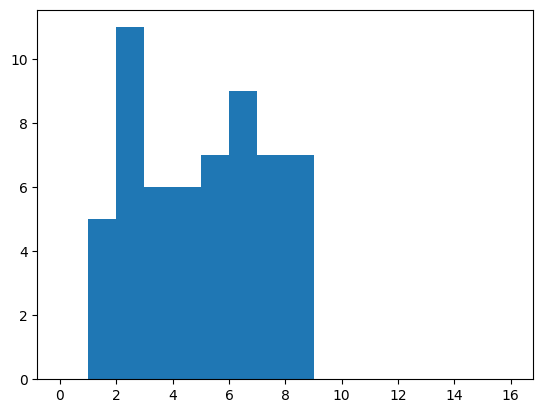

In [9]:
plt.hist(angle['move_no'], bins=range(0,17))
plt.show()

In [10]:
# for row in angle.itertuples():
#     arrow = row.SIGL_ARROW
#     # 위경도 추출
#     # arrow = re.findall(r'-?\d+\.?\d*', arrow)
#     arrow = [coord.lstrip(' ') for coord in arrow.split(',')]
#     arrow = [coord.lstrip('[') for coord in arrow]
#     arrow = [coord.rstrip(']') for coord in arrow]
#     exists = all([bool(coord) for coord in arrow])
#     if exists:
#         y1, x1, y2, x2, y3, x3 = arrow

#         # 미터 단위로 변환
#         x1, y1 = net.convertLonLat2XY(x1, y1)
#         x2, y2 = net.convertLonLat2XY(x2, y2)
#         x3, y3 = net.convertLonLat2XY(x3, y3)

#         # # 시각화
#         # plt.plot([x1, x2], [y1, y2], color='red')
#         # plt.plot([x2, x3], [y2, y3], color='blue')
#         # plt.scatter(x1, y1, color='k')
#         # plt.scatter(x2, y2, color='k')
#         # plt.scatter(x3, y3, color='k')
#         # plt.axis('equal')
#         # plt.title(f'inter_no : {row.inter_no}, ring_type : {row.ring_type}, move_no : {row.move_no}, angle_code : {row.angle_code}')
#         # plt.show()

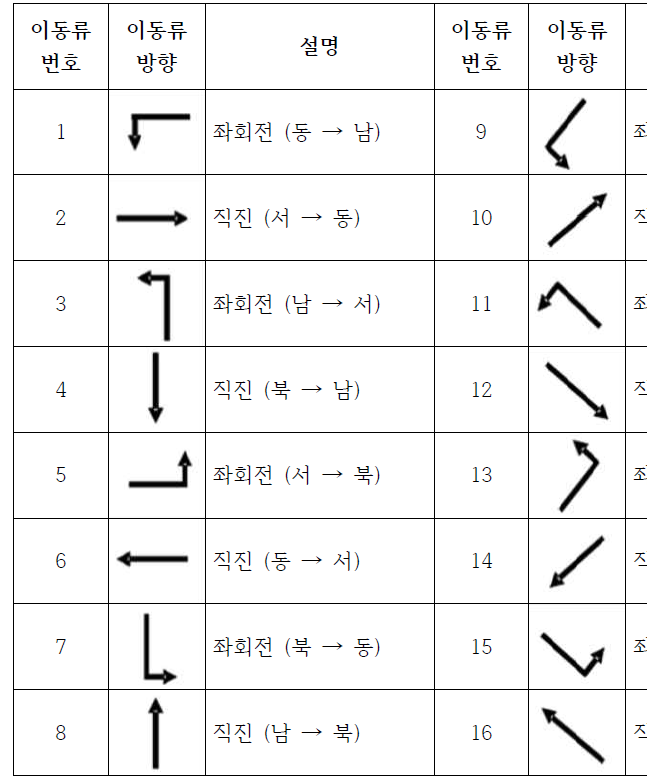

In [11]:
# from matplotlib_venn import venn2
# node_ids_net = set(node.getID() for node in net.getNodes())
# node_ids_IN  = {str(node_id) for node_id in inter_node.node_id.unique()}
# # for node_id in node_ids_net & node_ids_IN:
# #     try:
# #         node2inter[node_id]
# #     except KeyError as e:
# #         print(e)
# inter_nos_IN_net = {node2inter[node_id] for node_id in node_ids_net & node_ids_IN}
# # print(node_ids_net)
# # print(node_ids_IN)
# # venn2([node_ids_net, node_ids_IN])
# # plt.show()

In [12]:
# # inter_no가 등장하는 세 테이블 (inter_info, inter_node, angle)에서 inter_no 교집합 설정 후 적용
# inter_nos_inter_info = {int(inter_no) for inter_no in inter_info.inter_no.unique()}
# inter_nos_IN_net     = {int(inter_no) for inter_no in inter_node.inter_no.unique()}
# inter_nos_angle      = {int(inter_no) for inter_no in angle.inter_no.unique()}

# inter_nos = inter_nos_inter_info & inter_nos_IN_net & inter_nos_angle

# inter_info = inter_info[inter_info.inter_no.isin(inter_nos)]
# inter_node = inter_node[inter_node.inter_no.isin(inter_nos)]
# angle      = angle[angle.inter_no.isin(inter_nos)]
# angle = angle[['inter_no', 'move_no', 'angle_code']]

# inter_info.to_csv(os.path.join(path_table, 'inter_info.csv'), index=False)
# inter_node.to_csv(os.path.join(path_table, 'inter_node.csv'), index=False)
# angle.to_csv(os.path.join(path_table, 'angle.csv'), index=False)

In [13]:
turn_type = pd.read_csv(os.path.join(path_raw, 'turn_type_info.csv'), dtype=str)
turn_type = turn_type[turn_type.node_id.isin(node_ids)].reset_index(drop=True)
display(turn_type.head())

node_id inc_edge_id out_edge_id turn_type
0  106231      513136      513137  straight
1  106231      513136      513139      left
2  106231      513138      513135  straight
3  106231      513140      513137      left
4  106234      513152      513153      left

In [14]:
from io import StringIO
new_data = \
'''109986,	513785,	513842,	straight
106238,	513189,	513192,	straight
106238,	513189,	513194,	left
106238,	513193,	513188,	straight
106238,	513193,	513190,	left
106238,	513191,	513194,	straight
106238,	513191,	513188,	left
106238,	513195,	513190,	straight
106238,	513195,	513192,	left
106332,	519824,	513729,	straight
106332,	519824,	513731,	straight
106332,	519824,	513733,	left
106332,	519824,	513726,	left
106332,	513730,	513726,	straight
106332,	513730,	513728,	left
106332,	513732,	513728,	straight
106332,	513732,	513729,	left
106332,	513734,	513729,	straight
106332,	513734,	513731,	left
106332,	513727,	513729,	straight
106332,	513727,	513731,	left
106350,	513817,	513811,	straight
106350,	513792,	513816,	left
106350,	513810,	513816,	straight
106350,	513810,	513793,	left
109836,	517003,	517504,	straight
109836,	517003,	517506,	left
109836,	517002,	517506,	straight
109836,	517002,	517004,	left
109836,	517505,	517004,	straight
109836,	517505,	517507,	left
109836,	517509,	517507,	straight
109836,	517509,	517504,	left
109901,	513580,	513581,	straight
109901,	513582,	513584,	straight
'''

new_data_cleaned = "\n".join([",".join([col.strip() for col in row.split(",")]) for row in new_data.strip().split("\n")])
new_data_io = StringIO(new_data_cleaned)
new_df = pd.read_csv(new_data_io, sep=",", header=None, names=['node_id', 'inc_edge_id', 'out_edge_id', 'turn_type'])
new_df.head()

node_id  inc_edge_id  out_edge_id turn_type
0   109986       513785       513842  straight
1   106238       513189       513192  straight
2   106238       513189       513194      left
3   106238       513193       513188  straight
4   106238       513193       513190      left

In [15]:
turn_type = pd.concat([turn_type, new_df])
turn_type.to_csv(os.path.join(path_table, 'turn_type.csv'), index=False)

In [16]:
uturn = pd.read_csv(os.path.join(path_raw, 'uturn_data_info.csv'), dtype=str)
indices_to_be_removed = uturn.loc[((uturn.inc_edge_id=='514814')&(uturn.out_edge_id=='514823')) |
                                  ((uturn.inc_edge_id=='513124')&(uturn.out_edge_id=='513354'))].index
uturn = uturn.drop(indices_to_be_removed).reset_index(drop=True)
uturn = uturn[uturn.parent_id.isin(node_ids)]
uturn = uturn.replace({'515844':'517055'})
uturn.to_csv(os.path.join(path_table, 'uturn.csv'), index=False)

In [17]:
u_condition = uturn[['child_id']].copy()
u_condition['condition'] = '좌회전시'
u_condition.to_csv(os.path.join(path_table, 'u_condition.csv'), index=False)

In [18]:
uturn

parent_id child_id adj_inc_edge_id adj_out_edge_id inc_edge_id out_edge_id
0     106231   109295          513136          513135      519797      519796
1     106234   109296          513152          513151      519799      519798
2     106234   109297          513156          513155      519801      519800
6     108769   109333          513862          513863      519873      519874
14    109986   107587          517054          512766      516929      517055
15    109986   109313          513841          513840      519834      519833

In [19]:
inter_node

inter_no node_id inter_type
0       436  109836     parent
1       437  109986     parent
2       438  106350     parent
3       442  106332     parent
4       443  108769     parent
5       455  109901     parent
6       456  106231     parent
7       457  106234     parent
8       458  106238     parent

In [20]:
new_rows = []
for row in uturn.itertuples():
    parent_id = row.parent_id
    child_id = row.child_id
    inter_no = node2inter[parent_id]
    new_row = pd.DataFrame({'inter_no':[inter_no], 'node_id':[child_id], 'inter_type':['child']})
    new_rows.append(new_row)
inter_node = pd.concat([inter_node, *new_rows]).reset_index(drop=True)

In [21]:
# angle = angle[['inter_no', 'move_no', 'STOS_NO', 'angle_code']]

inter_info.to_csv(os.path.join(path_table, 'inter_info.csv'), index=False)
inter_node.to_csv(os.path.join(path_table, 'inter_node.csv'), index=False)
angle.to_csv(os.path.join(path_table, 'angle.csv'), index=False)

In [22]:
match1 = pd.read_csv(os.path.join(path_raw, 'TN_IF_SIGL_FLOW.csv'))
match1 = match1[['CRSRD_ID', 'PHASE', 'RING', 'FLOW_NO']]
match1 = match1.rename(columns={'CRSRD_ID':'inter_no',  'PHASE':'phase_no', 'RING':'ring_type', 'FLOW_NO':'move_no'})
match1 = match1.sort_values(by=['inter_no', 'phase_no', 'ring_type']).reset_index(drop=True)
match1 = match1[match1.move_no.isin(range(1,19))]
match1 = match1[match1.inter_no.isin(inter_nos)]
additional_m1s = []
for key, group in match1.groupby(['inter_no', 'phase_no']):
    inter_no, phase_no = map(int,key)
    if set(group.ring_type) != {'A', 'B'}:
        print('error', key)
        display(group)
        assert len(group)==1
        ring_type = group.iloc[0].ring_type
        RING_TYPE = list({'A', 'B'} - set(ring_type))[0]
        additional_m1 = group.copy()
        additional_m1['ring_type'] = RING_TYPE
        additional_m1s.append(additional_m1)
match1 = pd.concat([match1] + additional_m1s)
match1 = match1.reset_index(drop=True)

error (np.int64(456), np.int64(3))


inter_no  phase_no ring_type  move_no
60       456         3         A        7

error (np.int64(456), np.int64(4))


inter_no  phase_no ring_type  move_no
62       456         4         A       17

In [23]:
match1s = []
for key, group in match1.copy().groupby(['inter_no', 'phase_no']):
    inter_no, phase_no = map(int, key)
    assert len(group) == 2
    row_A = group[group.ring_type=='A']
    row_B = group[group.ring_type=='B']
    assert len(row_A)==len(row_B)==1
    row_A = row_A.iloc[0]
    row_B = row_B.iloc[0]
    m1 = pd.DataFrame({'inter_no':[inter_no], 'phas_A':[row_A.phase_no], 'phas_B':[row_B.phase_no],
                       'move_A':[row_A.move_no], 'move_B':[row_B.move_no]})
    match1s.append(m1)
match1 = pd.concat(match1s).reset_index(drop=True)
match1.to_csv(os.path.join(path_intermediates, 'match1.csv'), index=False)